In [1]:
import lecilab_behavior_analysis.utils as utils
import lecilab_behavior_analysis.df_transforms as dft
import lecilab_behavior_analysis.plots as plots
from lecilab_behavior_analysis.figure_maker import session_summary_figure, subject_progress_figure
from pathlib import Path
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time
from village.plots.corridor_plot import corridor_plot
import datetime


%load_ext autoreload
%autoreload 2

In [2]:
tv_projects = utils.get_server_projects()
chosen_project = "COT_cannula_data"
animals = utils.get_animals_in_project(chosen_project)
# animals_to_remove = ['test', 'test2']
# animals = [animal for animal in animals if animal not in animals_to_remove]
# retrieve the data for the remaining animals
for mouse in animals:
    local_path = Path(utils.get_outpath()) / Path(chosen_project) / Path("sessions") / Path(mouse)
    # create the directory if it doesn't exist
    local_path.mkdir(parents=True, exist_ok=True)
    # download the session data
    utils.rsync_cluster_data(
        project_name=chosen_project,
        file_path="sessions/{}/{}.csv".format(mouse, mouse),
        local_path=str(local_path),
        credentials=utils.get_idibaps_cluster_credentials(),
    )

df_list = []
for mouse in animals:
    local_path = Path(utils.get_outpath()) / Path(chosen_project) / Path("sessions") / Path(mouse)
    df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")
    df_list.append(df)
    print(f"Loaded data for {mouse}.")
# concatenate the dataframes
df = pd.concat(df_list, ignore_index=True)

receiving incremental file list
NUO001.csv

sent 6,097 bytes  received 102,206 bytes  43,321.20 bytes/sec
total size is 1,545,374  speedup is 14.27
receiving incremental file list
NUO002.csv

sent 6,307 bytes  received 111,887 bytes  78,796.00 bytes/sec
total size is 1,752,643  speedup is 14.83
receiving incremental file list
NUO003.csv

sent 7,759 bytes  received 99,580 bytes  42,935.60 bytes/sec
total size is 2,249,589  speedup is 20.96
receiving incremental file list
NUO004.csv

sent 7,777 bytes  received 176,368 bytes  122,763.33 bytes/sec
total size is 2,664,466  speedup is 14.47
receiving incremental file list
NUO005.csv

sent 7,489 bytes  received 107,603 bytes  46,036.80 bytes/sec
total size is 2,201,792  speedup is 19.13
receiving incremental file list
NUO006.csv

sent 7,651 bytes  received 117,788 bytes  83,626.00 bytes/sec
total size is 2,269,137  speedup is 18.09
receiving incremental file list
NUO007.csv

sent 6,469 bytes  received 127,489 bytes  53,583.20 bytes/sec
total 

In [3]:
df = dft.analyze_df(df)
print("Dataframe analyzed.")

Dataframe analyzed.


In [4]:
# plot the number of trials per day
df_to_plot = df.groupby(['subject', 'year_month_day', 'current_training_stage']).size().reset_index(name='trials')
# add also the correct percentage
df_to_plot_correct = df.groupby(['subject', 'year_month_day', 'current_training_stage'])[['correct', 'miss_trial']].mean().reset_index()
# merge the two dataframes
df_to_plot = df_to_plot.merge(df_to_plot_correct, on=['subject', 'year_month_day', 'current_training_stage'])
# sort the dataframe by date
df_to_plot = df_to_plot.sort_values(by=['year_month_day'])
# replace the current_training_stage values with more readable ones
df_to_plot['current_training_stage'] = df_to_plot['current_training_stage'].replace({
    'not saved': 'Habituation',
})

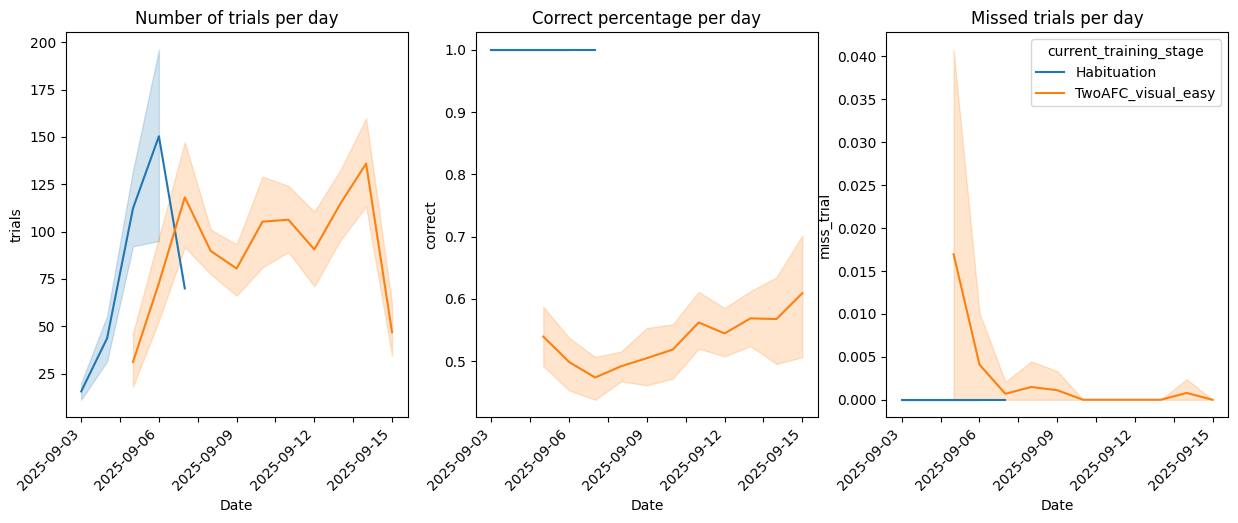

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.ravel()
sns.lineplot(data=df_to_plot, x='year_month_day', y='trials', hue='current_training_stage', ax=axs[0])
axs[0].set_title('Number of trials per day')
sns.lineplot(data=df_to_plot, x='year_month_day', y='correct', hue='current_training_stage', ax=axs[1])
axs[1].set_title('Correct percentage per day')
sns.lineplot(data=df_to_plot, x='year_month_day', y='miss_trial', hue='current_training_stage', ax=axs[2])
axs[2].set_title('Missed trials per day')
for ax in axs:
    ax.set_xlabel('Date')
    # tilt the x-axis labels and align them to the right
    ax.tick_params(axis='x', rotation=45)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), ha='right')
    # show up to 10 ticks on the x-axis
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
# remove legends
for ax in axs[:-1]:
    ax.legend_.remove()

plt.show()

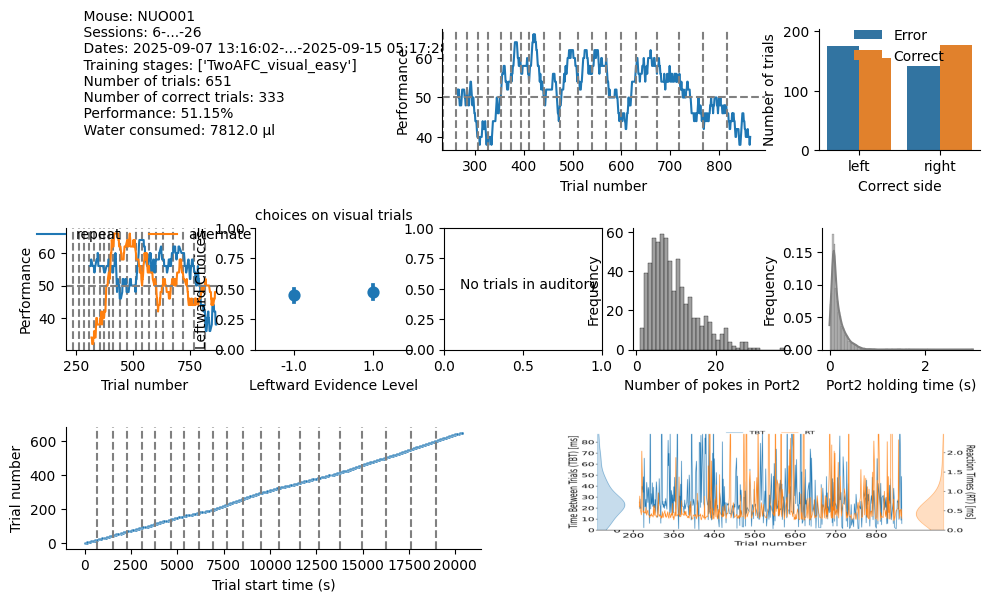

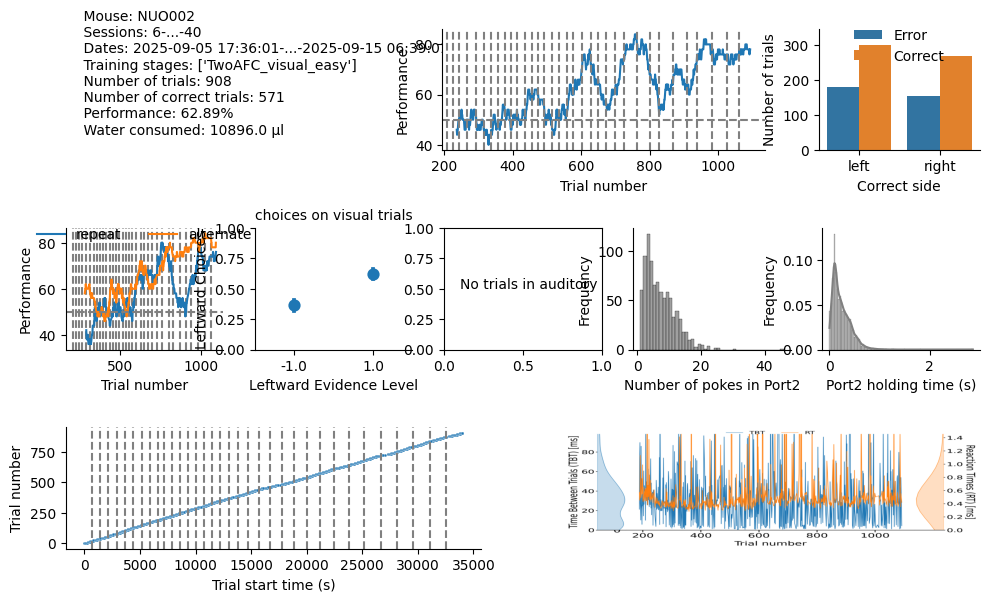

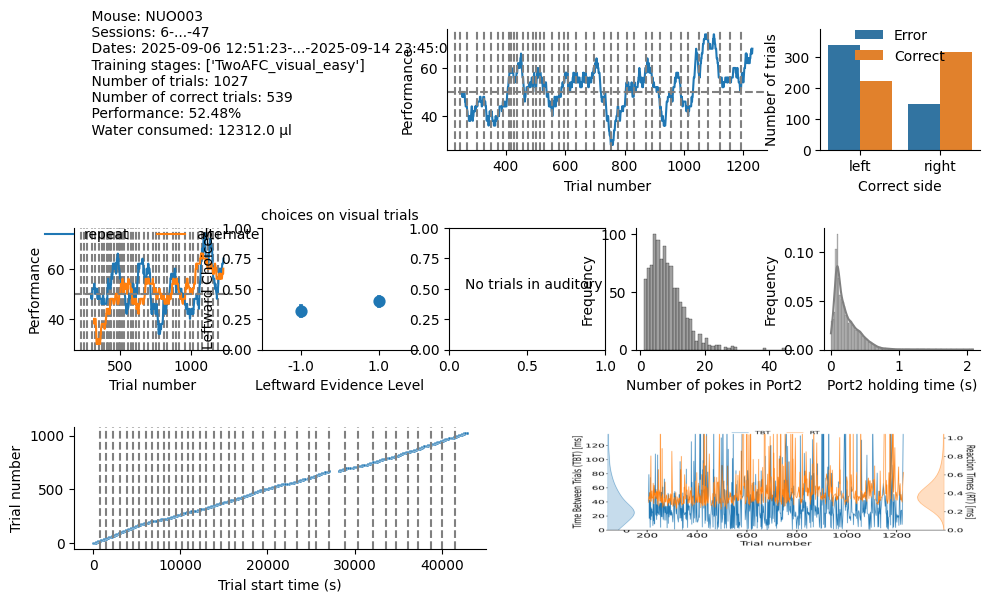

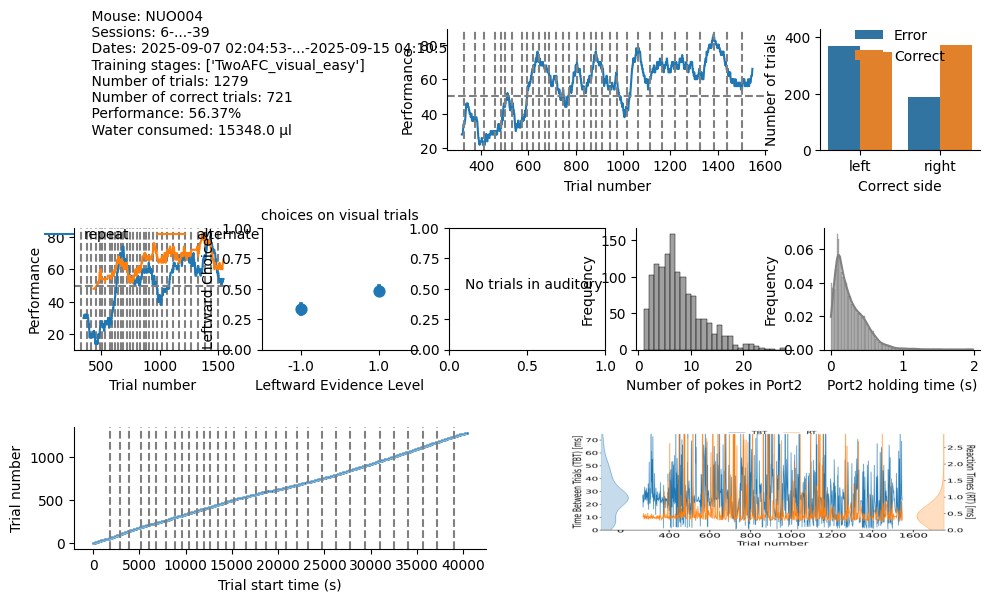

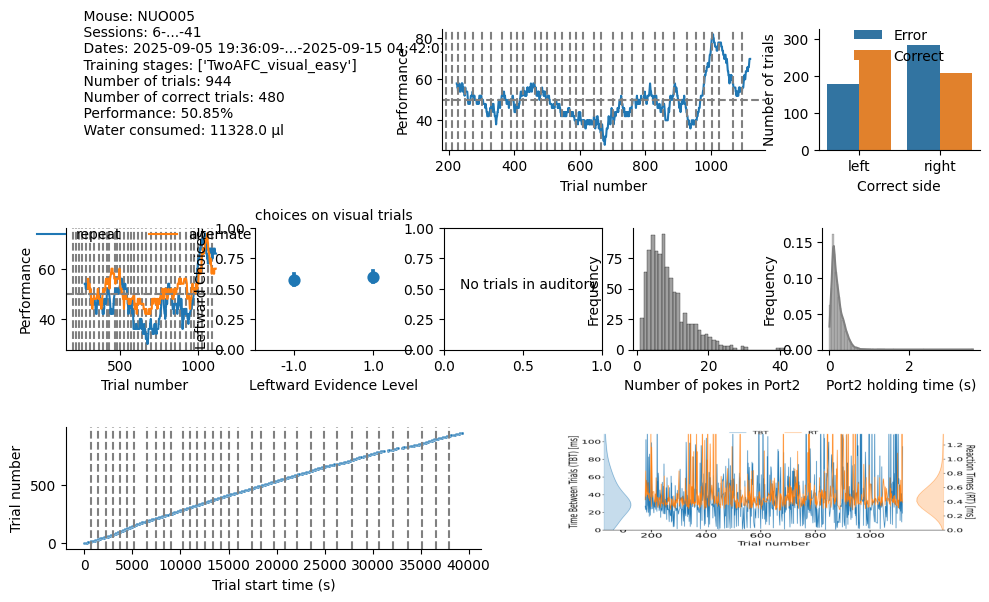

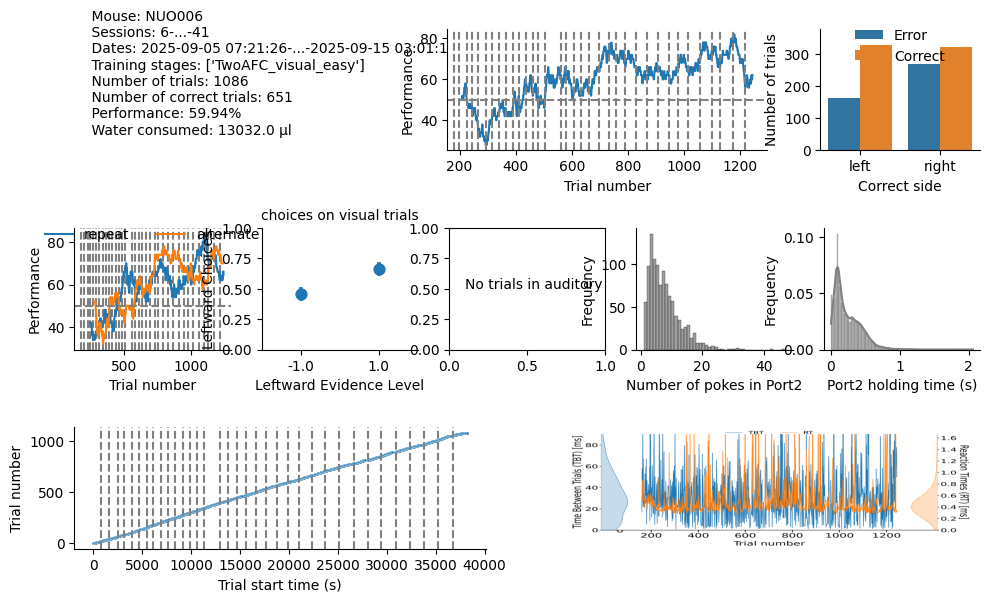

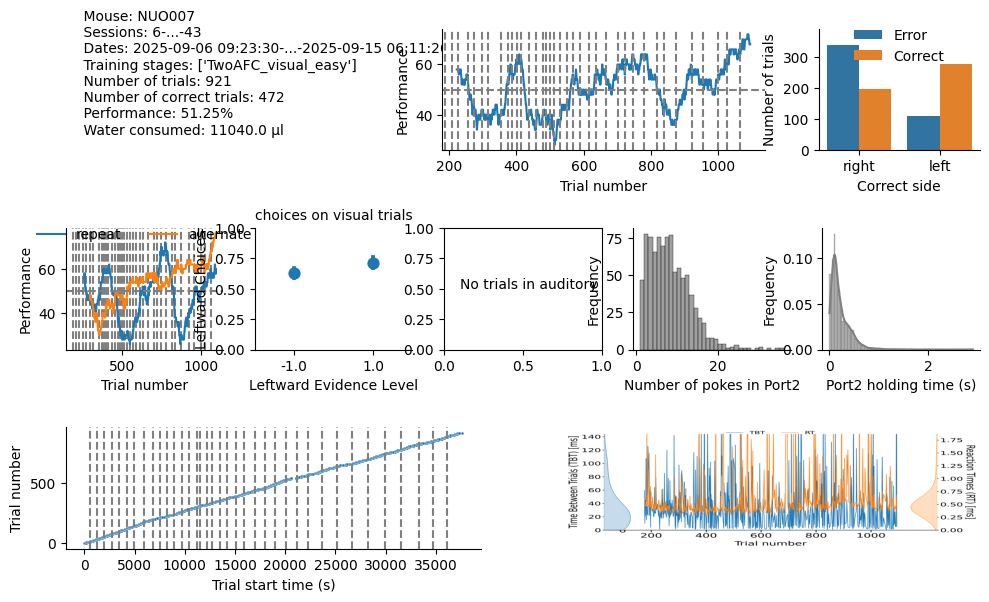

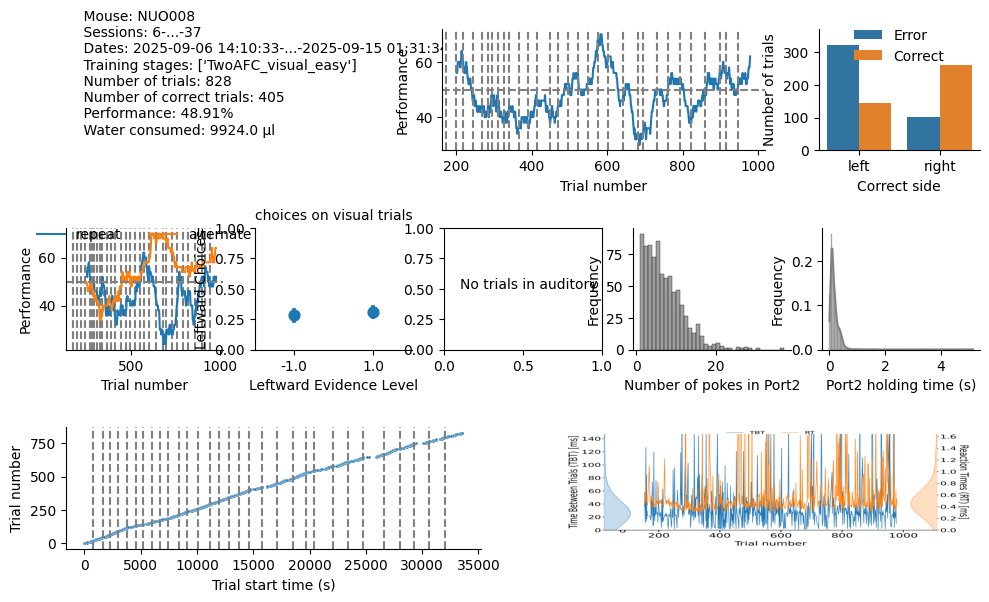

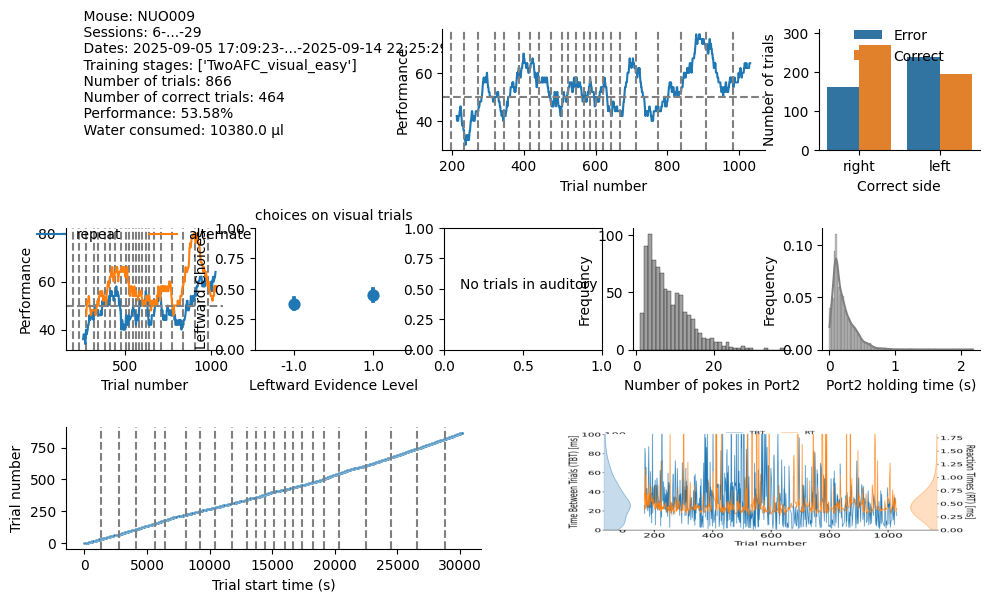

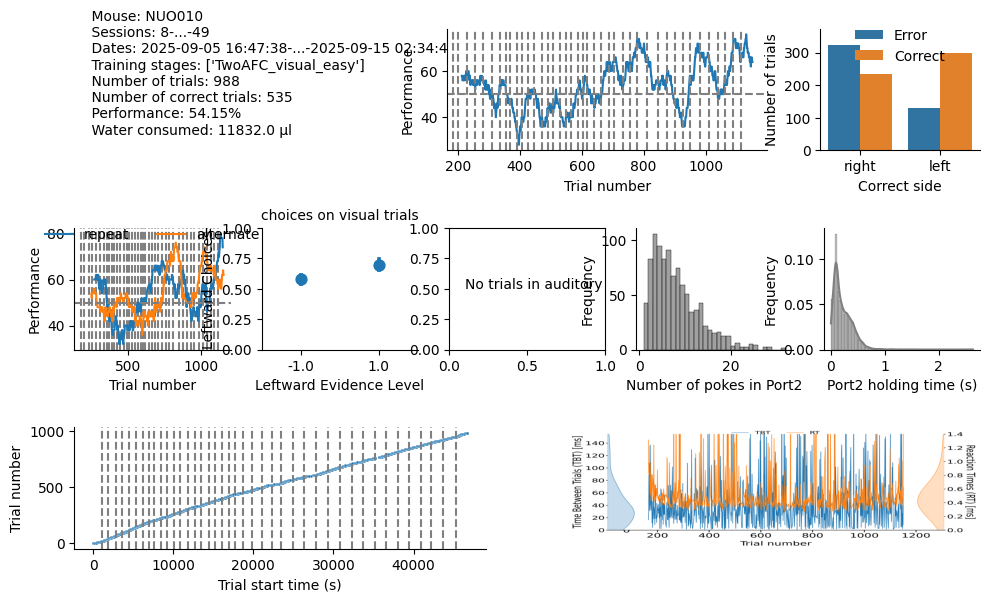

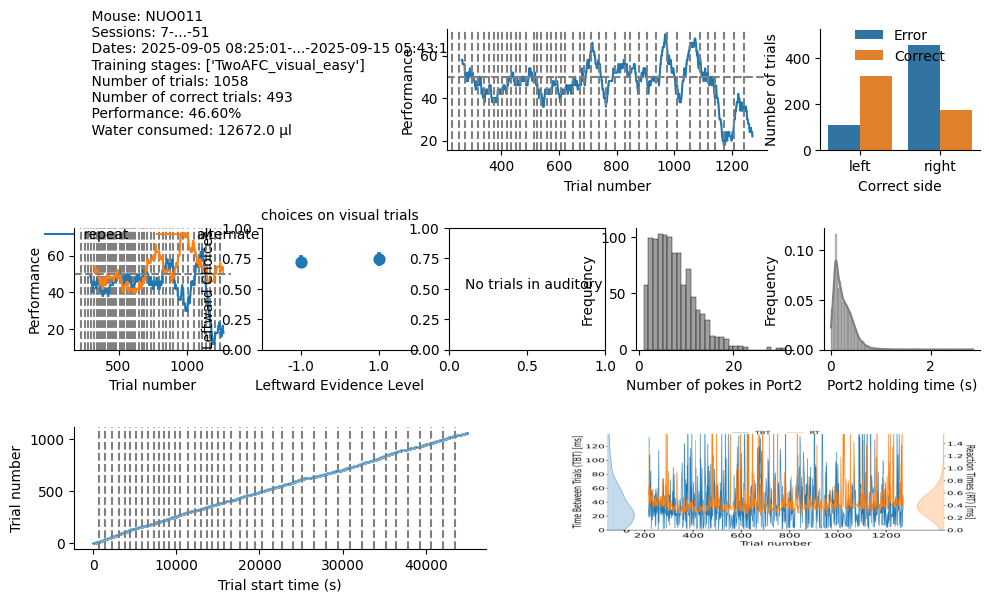

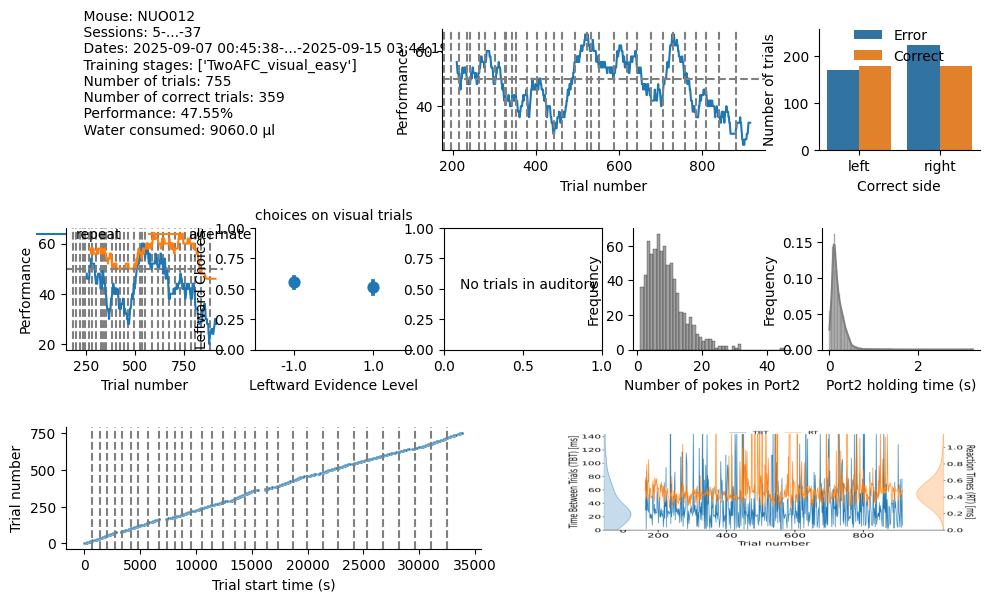

In [6]:
for chosen_animal in animals:
    df_animal = df[df['subject'] == chosen_animal]
    fig = session_summary_figure(df_animal[df_animal.current_training_stage == 'TwoAFC_visual_easy'])

/home/hmv/Github/lecilab-behavior-analysis/lecilab_behavior_analysis/df_transforms.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].fillna("not saved")
/home/hmv/Github/lecilab-behavior-analysis/lecilab_behavior_analysis/df_transforms.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["correct"] = df["correct"].infer_objects(copy=False)
/home/hmv/Github/lecilab-behavior-analysis/lecilab_behavior_analysis/df_transforms.py:15: SettingWithCopyWarning: 
A value is trying to be s

ValueError: malformed node or string: nan

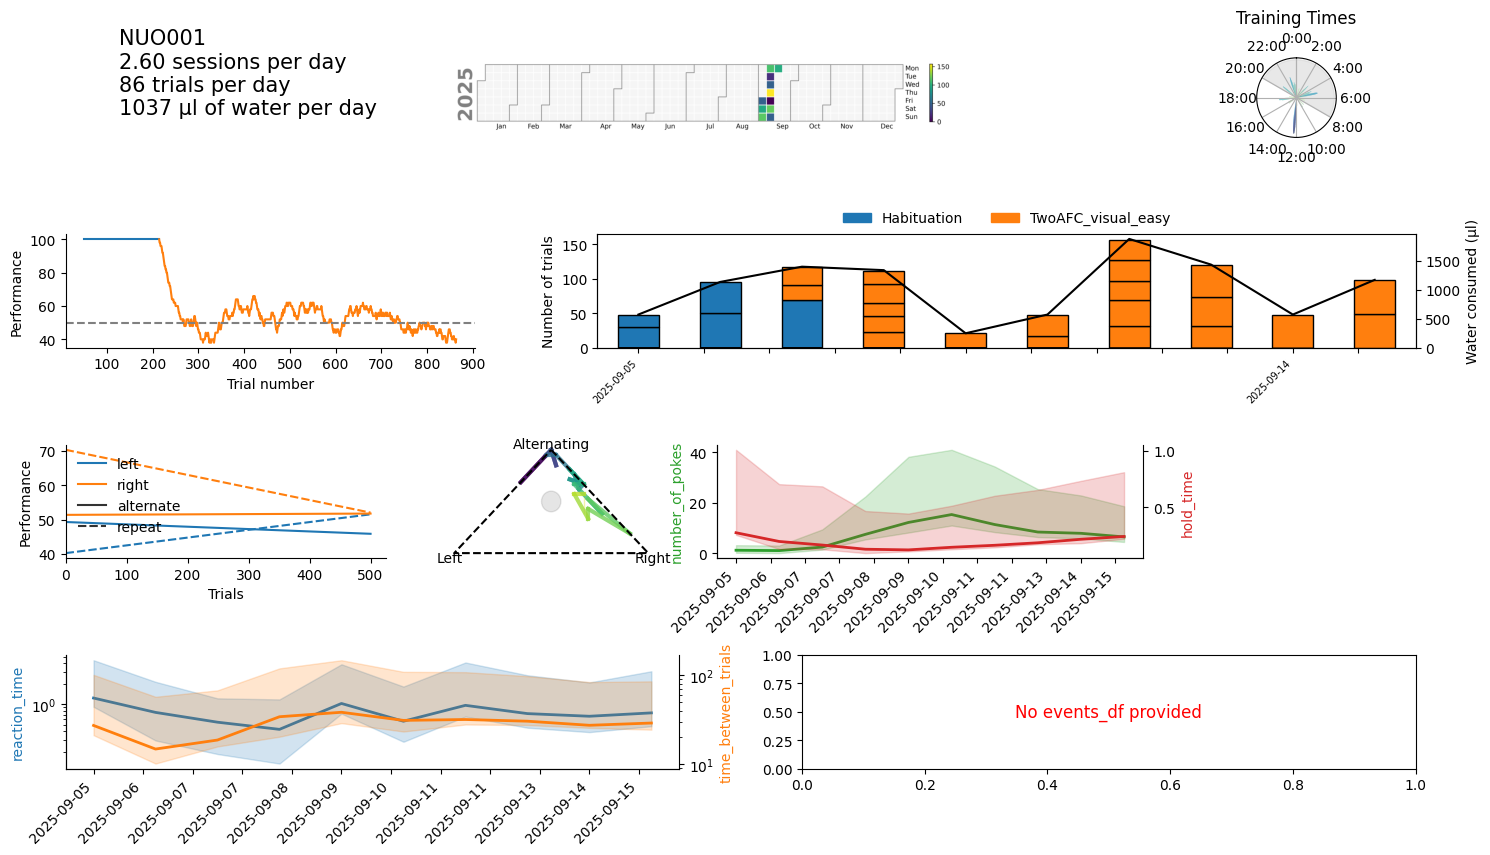

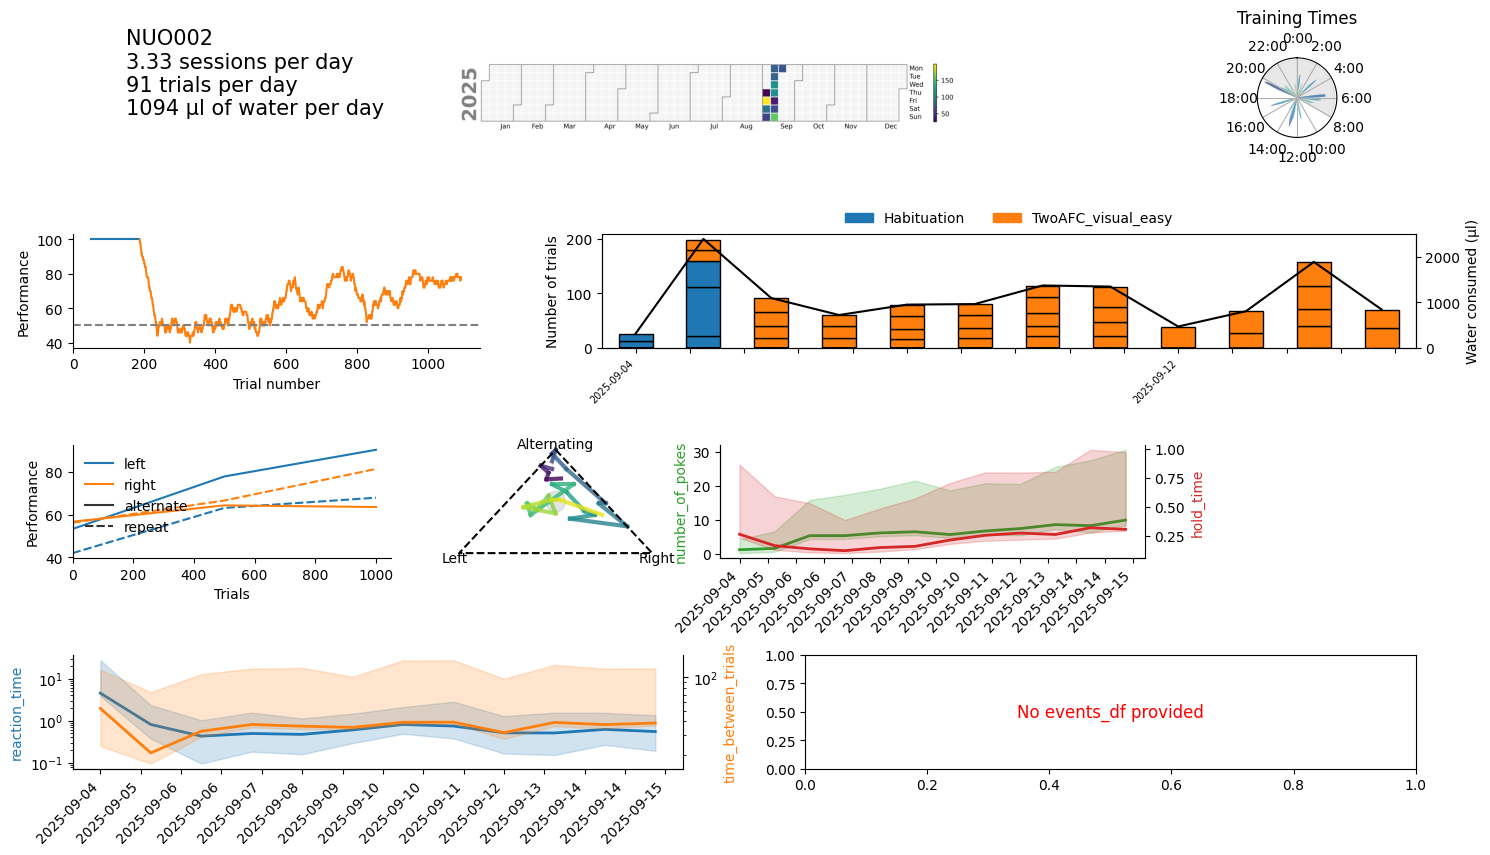

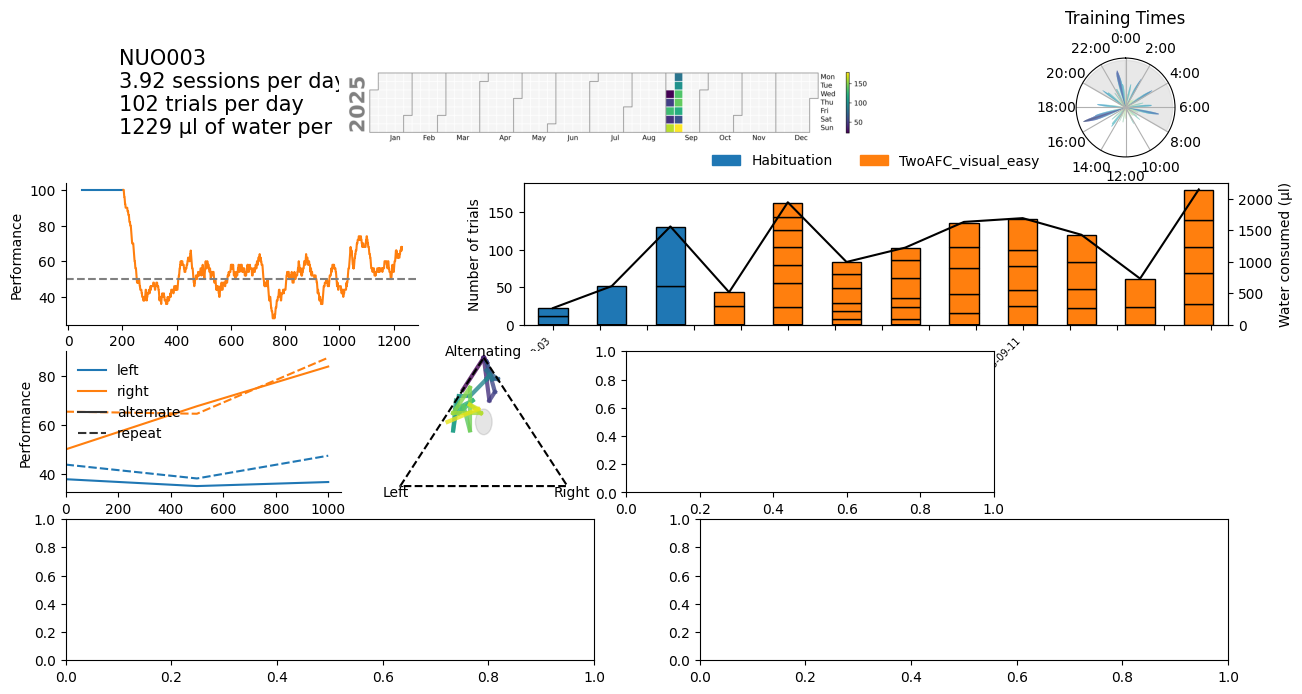

In [7]:
for chosen_animal in animals:
    df_animal = df[df['subject'] == chosen_animal]
    fig = subject_progress_figure(df_animal)